# CS 536 : Pruning Decision Trees

#### Submitted by Nitin Reddy Karolla (nrk60)

In [11]:
# Importing the required packages for the assignment

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mode

%matplotlib inline

### 1) Write a function to generate m samples of (X, Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?


In [14]:
def data_generator(m):
    """
    Input : 
        m - Number of samples
    
    Output : 
        Dataframe with k+1 columns i.e. k features that represent X 
        and 1 the represents Y
    """
    colnames = [ 'X'+ str(i)  for i in range(21)]
    
    X = [] 
    for j in range(m):
        y = []
        a = np.random.binomial(1, p=0.5, size= 1)[0]
        y.append(a)
        for i in range(14):
            x = np.random.binomial(1, p=0.75, size= 1)[0]
            if x == 1:
                y.append(a)
            else:
                y.append(1-a)
                a = 1-a
        for i in range(6):
            x = np.random.binomial(1, p = 0.5, size = 1)[0]
            y.append(x)
        X.append(y)
     
    df = pd.DataFrame(data= X, columns= colnames)
    
    #Generating the Y
    Y = []
    for i in X:
        if i[0] == 0:
            y = mode(i[1:8])
        else :
            y = mode(i[8:15])
        Y.append(y)
    
    #Generate column names
    df['Y'] = pd.Series(data = Y)
    return(df)

In [30]:
class Node():
    """
    Node is a data structure which will be used for decision trees.
    
    Input :
        data = training data post split is stored
        rule = feature on which the split led to this node and the 
        value of the feature
        child = nodes of children of all this node are present 
        after the split
    """
    def __init__(self,
                 data = None,
                 rule = None,
                 child = None,
                 depth = None
                ):
        self.data = data
        self.rule = rule
        self.child = child
        self.depth = depth

In [269]:
class Decision_Tree_ID3():
    """
    Decision Tree ID3 is trained on data with a target variable. It 
    is built on split variable which is indentified using the logic 
    of information gain 
    """
    def __init__(self, root = None, termination_depth = None, min_leaf_size = 4, sig_threshold = None, var = None):
        self.root = root
        self.termination_depth = termination_depth
        self.min_leaf_size = min_leaf_size
        self.sig_threshold = sig_threshold
        if var == None:
            self.var = []
        
    def _entropy(self, data, variable):
        """
        Calcuates the entropy for the given data and target variable
        """
        entropy_value = sum([(-data[variable].value_counts()[i]/ 
                              data[variable].count()) * np.log2((
            data[variable].value_counts()[i]/ 
            data[variable].count()) + 0.00000001) 
                             for i in data[variable].unique()])
        return entropy_value
    
    
    def _information_gain(self, data, variable, target):
        """
        Calculates the information gain for the given variable and data
        """
        infomation_content = sum([data[variable].value_counts()[i]/
                                  data[variable].count()
                                  * self._entropy(data[data[variable]== i], 
                                                 target) 
                                  for i in data[variable].unique()])
        info_gain = self._entropy(data, target) - infomation_content
        return(info_gain)
    
    
    def _split_variable_identification(self, data, target):
        """
        Identifies the split variable based on data and target
        """
        #loop through all features and calculate information gain for each feature
        variable_ig_required = list(data.columns)
        variable_ig_required.remove('Y')
        ig_values = [(i, self._information_gain(data,i,'Y')) 
                     for i in variable_ig_required]
        if len(ig_values) != 0:
            split_variable = max(ig_values, key = lambda item : item[1])
        else:
            split_variable = (0,0)
        return(split_variable)
    

    def _split_data(self, data, split_variable): 
        """
        Splits the data after identifying the split variable, assigns 
        data and rule to the node.
        """
        splitted_data = [Node(data = (data[data[split_variable] == i].
                                      drop(split_variable,1)),
                              rule = (split_variable,i)) 
                         for i in data[split_variable].unique()]
        return(splitted_data)
    
    
    def fit(self, data, target):
        """
        Fit is used to fit decision trees on the data for a given target variable
        """
        if type(data) != Node:
            data = Node(data = data, depth = 0)
            self.root = data
        
        #Terminating Conditions
        if self._split_variable_identification(data.data, target)[1] == 0 :
            return
        if data.depth == self.termination_depth:
            return
        if data.data.shape[0] <= self.min_leaf_size:
            return
        
        split_variable = self._split_variable_identification(data.data, target)[0]
        data.child = self._split_data(data.data, split_variable)
        for i in data.child:
            i.depth = data.depth + 1
               
        for i in data.child:
            if i.data['Y'].nunique() != 1:
                self.fit(i, target)
            
    
    def get_rules(self, model = None ,ruleList = None):
        """
        Returns the rules for each leaf and the major class in the leaf
        """
        if ruleList == None:
            ruleList = []
        if model == None:
            model = self.root
        ruleList.append(model.rule)
        if model.child == None:
            ruleList.append(model.data['Y'].mode()[0])
            return print(ruleList[1:])
        for i in model.child:
            self.get_rules(i,ruleList.copy())
            
    def get_irrelevant_variable(self, irrelevant_variables, model = None ):
        """
        Returns the count of irrelevant variables present in the decision tree
        """
           
        if model == None:
            model = self.root
        if model.child == None:
            return
        for i in model.child:
            if i.rule[0] in irrelevant_variables:
                self.var.append(i.rule[0])
                #print(var)
            self.get_irrelevant_variable(irrelevant_variables,i)
        return list(set(self.var))
    

    def _predict_row(self, model, row):
        """
        This function returns the prediction for the a single sample of 
        data using the fitted data
        """
        if model.child == None:
            return(model.data['Y'].mode()[0])

        variable = model.child[0].rule[0]
        row_value = row[variable]
        for i in model.child:
            if i.rule[1] == row_value:
                return self._predict_row(i, row)
            
    def predict(self, test):
        """
        Predict funtion will take an input data and return the prediction
        based on the fitted decision tree
        """
        predicted_y = []
        for i in test.iterrows():
            x = i[1]
            y = self._predict_row(self.root, x)
            predicted_y.append(y)
        return pd.Series(predicted_y)
    
    def training_error(self):
        """
        Returns the training error of the  fitted decision tree
        """
        predict_train = self.predict(data)
        return (1 -sum(data['Y'] == predict_train)/ len(data))
            

In [87]:
def typical_error(model, test_data_size, simulations = 50):
    """
    Generate error for similations for a generated test data and 
    given decision tree.
    """
    error = []
    for i in range(simulations):
        test_data = data_generator(test_data_size)
        predicted_y = model.predict(test_data)
        error_current = 1 -(sum(test_data['Y'] == predicted_y)/ len(test_data))
        error.append(error_current)
    return error

In [88]:
#Defining the repetitions values for generating m samples of training data
start = 400
end = 4000
step = 100

In [89]:
err_abs = []
m = []
for i in tqdm(range(start,end,step)):
    data = data_generator(i)
    dt = Decision_Tree_ID3()
    dt.fit(data, 'Y')
    err_f = typical_error(dt, 10)
    err_final = sum(err_f)/len(err_f)
    err_train = dt.training_error()
    m.append(i)
    #print( err_final, err_train)
    err_abs.append(abs(err_final-err_train))


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [16:41<00:00, 36.32s/it]


Text(0.5,1,'Marginal error vs the training size (m)')

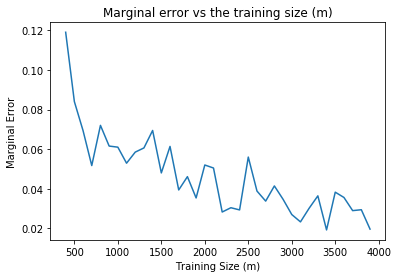

In [90]:
sns.lineplot(m,err_abs)
plt.xlabel("Training Size (m)")
plt.ylabel("Marginal Error")
plt.title("Marginal error vs the training size (m)")

### 2) Note that X15 through X20 are completely irrelevant to predicting the value of Y . For a range of m values, repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting on this noise?

In [232]:
irrelevant_variables = ['X15','X16','X17','X18','X19','X20']

In [277]:
x = data_generator(100)

In [278]:
trees = Decision_Tree_ID3()
trees.fit(x,'Y')

In [279]:
trees.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)

['X15', 'X18', 'X17']

In [290]:
def avg_irr_var(size, irrelevant_variables = irrelevant_variables, model_simulations = 10):
    out = []
    for i in range(model_simulations):
        tree = Decision_Tree_ID3()
        data = data_generator(m = size)
        tree.fit(data, 'Y')
        out.append(len(tree.get_irrelevant_variable(irrelevant_variables= irrelevant_variables)))
    return(sum(out)/len(out))

In [282]:
avg_irr_var(100)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [00:03<00:35,  3.95s/it]





 20%|████████████████▌                                                                  | 2/10 [00:08<00:33,  4.25s/it]





 30%|████████████████████████▉                                                          | 3/10 [00:13<00:30,  4.36s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [00:17<00:24,  4.11s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [00:21<00:20,  4.20s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:25<00:16,  4.13s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:28<00:11,  3.95s/it]

1.5

In [283]:
avg_irr_var(50)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.09s/it]





 20%|████████████████▌                                                                  | 2/10 [00:04<00:18,  2.28s/it]





 30%|████████████████████████▉                                                          | 3/10 [00:06<00:15,  2.14s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:13,  2.22s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [00:11<00:11,  2.24s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:14<00:09,  2.38s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:16<00:06,  2.30s/it]

1.2

In [284]:
avg_irr_var(500)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [00:12<01:48, 12.10s/it]





 20%|████████████████▌                                                                  | 2/10 [00:25<01:40, 12.50s/it]





 30%|████████████████████████▉                                                          | 3/10 [00:38<01:27, 12.50s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [00:49<01:13, 12.21s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [01:03<01:04, 12.81s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:16<00:51, 12.88s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:29<00:38, 12.90s/it]

2.3

In [285]:
avg_irr_var(5000)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [00:42<06:18, 42.05s/it]





 20%|████████████████▌                                                                  | 2/10 [01:23<05:35, 41.96s/it]





 30%|████████████████████████▉                                                          | 3/10 [02:03<04:48, 41.23s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [02:40<03:59, 39.98s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [03:22<03:23, 40.64s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:02<02:41, 40.49s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:44<02:02, 40.82s/it]

3.4

In [286]:
avg_irr_var(25000)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [01:08<10:15, 68.39s/it]





 20%|████████████████▌                                                                  | 2/10 [02:12<08:56, 67.03s/it]





 30%|████████████████████████▉                                                          | 3/10 [03:23<07:57, 68.15s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [04:34<06:55, 69.19s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [05:42<05:43, 68.65s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [06:52<04:37, 69.31s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:07<03:32, 70.91s/it]

3.2

In [287]:
avg_irr_var(100000)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████▎                                                                          | 1/10 [01:33<13:59, 93.28s/it]





 20%|████████████████▌                                                                  | 2/10 [03:08<12:30, 93.81s/it]





 30%|████████████████████████▉                                                          | 3/10 [04:41<10:55, 93.67s/it]





 40%|█████████████████████████████████▏                                                 | 4/10 [06:13<09:19, 93.25s/it]





 50%|█████████████████████████████████████████▌                                         | 5/10 [07:47<07:46, 93.39s/it]





 60%|█████████████████████████████████████████████████▊                                 | 6/10 [09:26<06:20, 95.13s/it]





 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:04<04:47, 95.84s/it]

1.6

In [288]:
start = 10
end = 1000011
step = 50000

In [ ]:
average_irr_var = []
m = []
for i in tqdm(range(start,end,step)):
    m.append(i)
    #print( err_final, err_train)
    average_irr_var.append(avg_irr_var(i))
    
    









  0%|                                                                                           | 0/21 [00:00<?, ?it/s]







  5%|███▉                                                                               | 1/21 [00:05<01:52,  5.64s/it]







 10%|███████▌                                                                        | 2/21 [13:37<1:18:25, 247.64s/it]







 14%|███████████▍                                                                    | 3/21 [29:36<2:18:18, 461.01s/it]







 19%|███████████████▏                                                                | 4/21 [47:53<3:04:40, 651.79s/it]







 24%|██████████████████▌                                                           | 5/21 [1:07:54<3:37:42, 816.38s/it]

Text(0.5,1,'Marginal error vs the training size (m)')

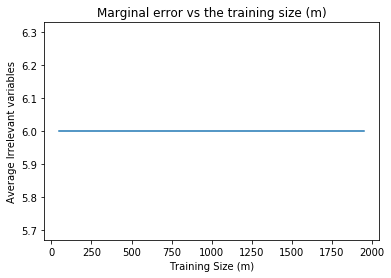

In [190]:
sns.lineplot(m,average_irr_var)
plt.xlabel("Training Size (m)")
plt.ylabel("Average Irrelevant variables")
plt.title("Marginal error vs the training size (m)")

### 3) Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The remaining questions should all be applied to this data set.

### a) Pruning by Depth: 
#### Consider growing a tree as a process - running ID3 for instance until all splits up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training set and the error on the test set for a tree grown to depth d. What does your data suggest as a good threshold depth?
